https://www.tensorflow.org/tutorials/keras/basic_classification

https://github.com/Zackory/Keras-MNIST-GAN/blob/master/mnist_gan.py


In [14]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.datasets import mnist
from keras.optimizers import Adam, SGD
from keras import backend as K
from keras import initializers

K.set_image_dim_ordering('th')

from keras.layers.advanced_activations import LeakyReLU

In [15]:
tr_im = np.loadtxt("reals.dat")

In [16]:
tr_im.shape

(20000, 4000)

In [17]:
nrow,ncol = 80,50

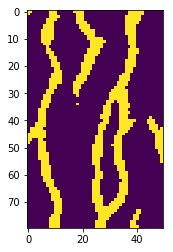

In [18]:
plt.imshow(tr_im[0,:].reshape((nrow,ncol)))

In [19]:
npar = 100 #number of standard normal deviates to feed to generator input

In [28]:
#opt = tf.train.AdamOptimizer(learning_rate=0.0005,beta1=0.5)
opt_gen = Adam(lr=0.0002,beta_1=0.5)
opt_dis = SGD(lr= 0.0001)

In [29]:
tr_im.max(),tr_im.min()

(1.0, 0.0)

In [36]:
generator = Sequential()
generator.add(Dense(100*8*5, input_shape=(npar,), kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(LeakyReLU(0.2))
generator.add(Reshape((100, 8, 5)))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(256, kernel_size=3, padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(Conv2D(128, kernel_size=3, padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(Conv2D(64, kernel_size=3, padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(UpSampling2D(size=(5, 5)))
generator.add(Conv2D(1, kernel_size=3, padding='same', activation='sigmoid'))
generator.compile(loss='binary_crossentropy', optimizer=opt_gen)
generator.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 4000)              404000    
_________________________________________________________________
leaky_re_lu_29 (LeakyReLU)   (None, 4000)              0         
_________________________________________________________________
reshape_5 (Reshape)          (None, 100, 8, 5)         0         
_________________________________________________________________
up_sampling2d_9 (UpSampling2 (None, 100, 16, 10)       0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 256, 16, 10)       230656    
_________________________________________________________________
leaky_re_lu_30 (LeakyReLU)   (None, 256, 16, 10)       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 128, 16, 10)       295040    
__________

In [37]:
# Discriminator
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=3, strides=(2, 2), padding='same', input_shape=(1, 80, 50), kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=3, strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(256, kernel_size=3, strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(512, kernel_size=3, strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=opt_gen)
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 64, 40, 25)        640       
_________________________________________________________________
leaky_re_lu_33 (LeakyReLU)   (None, 64, 40, 25)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 64, 40, 25)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 128, 20, 13)       73856     
_________________________________________________________________
leaky_re_lu_34 (LeakyReLU)   (None, 128, 20, 13)       0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 128, 20, 13)       0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 256, 10, 7)        295168    
__________

In [38]:
discriminator.trainable = False
gi = Input(shape=(npar,))
x = generator(gi)
go = discriminator(x)
gan = Model(inputs=gi,outputs=go)
gan.compile(loss="binary_crossentropy",optimizer=opt)

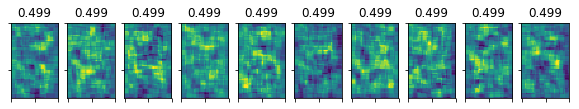

In [39]:

def plot_gen():
    fig, axes = plt.subplots(nrows=1,ncols=10,figsize = (10,10))
    plot_noise = np.random.randn(10,npar) 
    vecs = generator.predict(plot_noise)#.reshape(10,28,28)
    isreal = discriminator.predict(vecs)
    #print(isreal.shape)
    for ax,vec,real in zip(axes.flatten(),vecs.reshape(10,nrow,ncol),isreal.flatten()):
        ax.imshow(vec)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_title("{0:1.3G}".format(real))
plot_gen()
#generator.save("test.h5")
o_d = "gen_models"
if os.path.exists(o_d):
    shutil.rmtree(o_d)
os.mkdir(o_d)

78


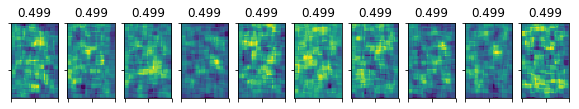

1 2.0388076 0.2802302557


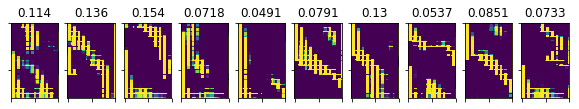

2 1.7292768 0.3836878228


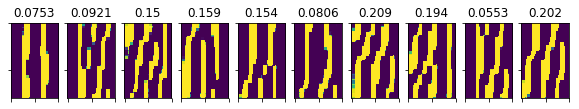

In [40]:
batch_size = 256
batch_count = int(tr_im.shape[0] / batch_size)
print(batch_count)
plot_gen()
plt.show()
for e in range(1,400):
    for bc in range(batch_count):
        noise = np.random.randn(batch_size,npar)
        tr_im_batch = tr_im[np.random.randint(0,tr_im.shape[0],size=batch_size)]
        gen_im = generator.predict(noise)
        tr_im_batch = np.resize(tr_im_batch,(batch_size,1,nrow,ncol))
        #print(gen_im.shape,tr_im_batch.shape)
        tr_im_batch = np.concatenate([tr_im_batch,gen_im])
        #noisy labels and flipped labels...
        tr_im_lab = np.zeros(tr_im_batch.shape[0])
        if False:#np.random.rand(1) <= 0.05:
            tr_im_lab[batch_size:] = np.random.uniform(0.9,1.0,size=batch_size)
            tr_im_lab[:batch_size] = np.random.uniform(0.0,0.1,size=batch_size)
        else:
            tr_im_lab[:batch_size] = np.random.uniform(0.9,1.0,size=batch_size)
            tr_im_lab[batch_size:] = np.random.uniform(0.0,0.1,size=batch_size)
        discriminator.trainable = True
        dloss = discriminator.train_on_batch(tr_im_batch,tr_im_lab)
        noise = np.random.randn(batch_size,npar)
        tr_img_lab = np.ones(batch_size)
        discriminator.trainable = False
        gloss = gan.train_on_batch(noise,tr_img_lab)
        print(bc,gloss,dloss,end="\r")
    if e % 1 == 0:
        print(e,gloss,dloss)
        plot_gen()
        plt.show()
        generator.save(os.path.join(o_d,"gen_{0}.h5").format(e))
        
    